# Home Credit Default Risk
@edwardp17, @edgarpavlovsky

----

## Ideas moving forward:
1. Create more robust NN model
    a. Ideas:
        https://www.kaggle.com/javapocalypse/breast-cancer-classification-in-keras-using-ann
        http://parneetk.github.io/blog/neural-networks-in-keras/
2. Find way for NN to use roc auc as loss metric to optimize
3. Would filling in missing values differently make a significant difference?
    a. I was thinking maybe cluster before filling in missing NAN values, then use the means/medians of the columns based on the clusters

Since these models are using both the test and training sets for preprocessing, this might be considered leakage
For now, we will accept this leakage as we want to make our model as accurate as possible for competition purposes
Once a solid model is build, we will try preprocessing without the test set, and rerun; then go from there

## Import libraries and configure notebook

Import and configure general libraries:

In [0]:
import os
import gc
gc.enable()
import random
import numpy as np 
import pandas as pd
pd.set_option('display.height', 2000)
pd.set_option('display.max_rows', 2000)

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set()
from IPython.display import display

Import machine learning libraries:

In [0]:
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import classification algorithm modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import classification_report, roc_auc_score

Import PyDrive:

In [0]:
# Import PyDrive

# if PyDrive hasn't been installed, run:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Load data

In [0]:
class Dataset:
  
  def __init__(self, filename, file_id):
    
    self.filename = filename
    self.file_id = file_id
    self.drive_file = drive.CreateFile({'id': self.file_id})
    self.df = None

    
  def save_to_colab(self):
    
    self.drive_file.GetContentFile(self.filename)
    
    
  def create_dataframe(self):
    
    try:
      
      return pd.read_csv(self.filename)
    
    except:
      
      self.save_to_colab()
      return pd.read_csv(self.filename)

In [0]:
drive_files_ids = {
    'application_test.csv': '1iCv5mT_HGXAMY0wSS0FleH7diKQd1F83',
    'application_train.csv': '1D30vNL-K_jKBy81qKl64dMY_0xNyr6n7',
    'bureau_balance.csv': '1eUzTy9FLXZXo_zA2WGssOdk9DmKwFxn1',
    'bureau.csv': '1bMPfM10MGLD8jOvEuYYD9BvV_tJ9vzOq',
    'credit_card_balance.csv': '1PrQTHXyxU8swAqr2pm2x_NINzvYo7ljl',
    'installments_payments.csv': '1_c1yp4WNhG3MjD2_4hoI3Qu0UVgk7FuY',
    'POS_CASH_balance.csv': '1GiX1CR0mgaj8sZ2VaAmYQQ2sHaQqldtK',
    'previous_application.csv': '1FvkycXPEONQB-ngIygTeuLjU5HgCLZF5'
  #     'HomeCredit_columns_description.csv': '10uALeL7ZGLtRvxONebNDuAcbizP4O8QJ',
  #     'sample_submission.csv': '1DtHBHfvoMwThsfd9Rn5kfOSn3NyiBs2q',
}

In [174]:
# only needs to run if datasets haven't been loaded into colab
# datasets = []
# for filename in list(drive_files_ids.keys()):
  
#   print('Uploading ' + filename)
#   dataset = Dataset(filename,drive_files_ids[filename])
  
#   print('Creating dataframe from ' + filename)
#   dataset.df = dataset.create_dataframe()

Uploading application_test.csv
Creating dataframe from application_test.csv
Uploading application_train.csv
Creating dataframe from application_train.csv
Uploading bureau_balance.csv
Creating dataframe from bureau_balance.csv
Uploading bureau.csv
Creating dataframe from bureau.csv
Uploading credit_card_balance.csv
Creating dataframe from credit_card_balance.csv
Uploading installments_payments.csv
Creating dataframe from installments_payments.csv
Uploading POS_CASH_balance.csv
Creating dataframe from POS_CASH_balance.csv
Uploading previous_application.csv
Creating dataframe from previous_application.csv


In [0]:
# Uncomment this for kaggle
# pos = pd.read_csv('../input/POS_CASH_balance.csv')
# test = pd.read_csv('../input/application_test.csv')
# train = pd.read_csv('../input/application_train.csv')
# bureau = pd.read_csv('../input/bureau.csv')
# bureau_balance = pd.read_csv('../input/bureau_balance.csv')
# cc_bal = pd.read_csv('../input/credit_card_balance.csv')
# inst = pd.read_csv('../input/installments_payments.csv')
# prev_app = pd.read_csv('../input/previous_application.csv')
# sample_submission = pd.read_csv('../input/sample_submission.csv')


# Uncomment this for local
# pos = pd.read_csv('data/POS_CASH_balance.csv')
# test = pd.read_csv('data/application_test.csv')
# train = pd.read_csv('data/application_train.csv')
# bureau = pd.read_csv('data/bureau.csv')
# bureau_balance = pd.read_csv('data/bureau_balance.csv')
# cc_bal = pd.read_csv('data/credit_card_balance.csv')
# inst = pd.read_csv('data/installments_payments.csv')
# prev_app = pd.read_csv('data/previous_application.csv')
# sample_submission = pd.read_csv('data/sample_submission.csv')

# Uncomment this for colab
pos = pd.read_csv('POS_CASH_balance.csv')
test = pd.read_csv('application_test.csv')
train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
cc_bal = pd.read_csv('credit_card_balance.csv')
inst = pd.read_csv('installments_payments.csv')
prev_app = pd.read_csv('previous_application.csv')
# sample_submission = pd.read_csv('sample_submission.csv')

In [60]:
# If we need them, we have original, untouched dataframes in our objects stored in the `datasets` list
dfs = [pos, test, train, bureau, bureau_balance, cc_bal, inst, prev_app]

for df in dfs:
  print(df.shape)

(10001358, 8)
(48744, 121)
(307511, 122)
(1716428, 17)
(27299925, 3)
(3840312, 23)
(13605401, 8)
(1386780, 37)


## Preprocessing

#### `application_train`:

In [0]:
target = ['TARGET']

features = [x for x in list(train.columns) if x != 'TARGET']

In [0]:
train_features = train[features]

In [72]:
train_features.shape

(307511, 121)

In [70]:
sorted(list(train_features.columns))

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

Take a look at the % null in each column:

In [0]:
train_features_nulls = pd.DataFrame(train_features.isnull().sum()).reset_index()
train_features_nulls.columns = ['column','nulls_num']
train_features_nulls['nulls_perc'] = train_features_nulls.nulls_num.apply(lambda x: x / len(train_features))

In [93]:
train_features_nulls.sort_values(by='column')

,column,nulls_num,nulls_perc
8,AMT_ANNUITY,12,0.000039
7,AMT_CREDIT,0,0.000000
9,AMT_GOODS_PRICE,278,0.000904
6,AMT_INCOME_TOTAL,0,0.000000
116,AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016
115,AMT_REQ_CREDIT_BUREAU_HOUR,41519,0.135016
118,AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016
119,AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016
117,AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016
120,AMT_REQ_CREDIT_BUREAU_YEAR,41519,0.135016


It looks like groups of columns have the exact same number of nulls, meaning that it's like the same samples have nulls within groups of columns. We can group train_features_nulls by nulls_num (or nulls_perc, should yield the same result) and count the number of columns that have the same exact numbers of nulls:

In [77]:
train_null_groups = train_features_nulls.groupby(by='nulls_num')['column'].count().reset_index()
train_null_groups.sort_values(by='column',ascending=False)

,nulls_num,column
0,0,54
8,41519,6
6,1021,4
14,153020,3
30,213514,3
28,210199,3
27,208642,3
26,204488,3
24,182590,3
23,179943,3


This gives us some helpful information:

54 columns have 0 nulls
Groups of 3-6 columns can be derived by the number of nulls. We can look through these to see if the groups are interesting:

In [78]:
for x in list(train_null_groups.nulls_num):
    if x != 0:
        num_cols = len(train_features_nulls.loc[train_features_nulls.nulls_num == x,:])
        if num_cols > 1:
            print('----')
            print('nulls_num: '+str(x))
            print(train_features_nulls.loc[train_features_nulls.nulls_num == x,:])

----
nulls_num: 1021
                      column  nulls_num  nulls_perc
90  OBS_30_CNT_SOCIAL_CIRCLE       1021     0.00332
91  DEF_30_CNT_SOCIAL_CIRCLE       1021     0.00332
92  OBS_60_CNT_SOCIAL_CIRCLE       1021     0.00332
93  DEF_60_CNT_SOCIAL_CIRCLE       1021     0.00332
----
nulls_num: 41519
                         column  nulls_num  nulls_perc
115  AMT_REQ_CREDIT_BUREAU_HOUR      41519    0.135016
116   AMT_REQ_CREDIT_BUREAU_DAY      41519    0.135016
117  AMT_REQ_CREDIT_BUREAU_WEEK      41519    0.135016
118   AMT_REQ_CREDIT_BUREAU_MON      41519    0.135016
119   AMT_REQ_CREDIT_BUREAU_QRT      41519    0.135016
120  AMT_REQ_CREDIT_BUREAU_YEAR      41519    0.135016
----
nulls_num: 150007
                          column  nulls_num  nulls_perc
45   YEARS_BEGINEXPLUATATION_AVG     150007     0.48781
59  YEARS_BEGINEXPLUATATION_MODE     150007     0.48781
73  YEARS_BEGINEXPLUATATION_MEDI     150007     0.48781
----
nulls_num: 153020
            column  nulls_num  nulls_perc


Looks like all the column groups are named really similarly, and there are no groups of columns with the same exact nulls that aren't similarly named. This means these nulls could have come from LEFT JOINing data sources together, for lack of a sleeker way to put that.

Let's look at the descriptions for each column in the dataset. schema [here](https://docs.google.com/spreadsheets/d/1WPC7ULTv-GsYbz6FoBuS8ar2DHHVIVqoNjFnIhgg8a0/edit?usp=sharing).

`SK_ID_CURR` is the "ID of loan in our sample". Since it's a unique ID, it's likely not relevant for our model. It could _potentially_ be relevant if unique IDs are numerical, created incrementally, and if we want to use this unique ID to determien the # loan that was extended to each client. We'll exclude it for now.

In [0]:
exclude_vars = ['SK_ID_CURR']

`NAME_CONTRACT_TYPE` is the "Identification if loan is cash or revolving". This is a categorical column that we can create dummies from. If we want to reduce dimensions while maintaining richness, we could also transform this into a binary variable.

In [81]:
train_features.NAME_CONTRACT_TYPE.unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [0]:
cat_vars = ['NAME_CONTRACT_TYPE']

`CODE GENDER` is the "Gender of the client". It looks like there are 3 genders.

In [82]:
train_features.CODE_GENDER.unique()

array(['M', 'F', 'XNA'], dtype=object)

In [0]:
cat_vars.append('CODE GENDER')

`FLAG_OWN_CAR` and `FLAG_OWN_REALTY` are binary variables and won't need to be transformed.

In [0]:
binary_vars = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']

In fact, we can do a quick check to make sure all `FLAG_*` columns really are flags:

In [88]:
for col in list(train_features.columns):
  
  if col.split('_')[0] == 'FLAG':
    
    print(col, train_features[col].min(), train_features[col].max())

FLAG_OWN_CAR N Y
FLAG_OWN_REALTY N Y
FLAG_MOBIL 0 1
FLAG_EMP_PHONE 0 1
FLAG_WORK_PHONE 0 1
FLAG_CONT_MOBILE 0 1
FLAG_PHONE 0 1
FLAG_EMAIL 0 1
FLAG_DOCUMENT_2 0 1
FLAG_DOCUMENT_3 0 1
FLAG_DOCUMENT_4 0 1
FLAG_DOCUMENT_5 0 1
FLAG_DOCUMENT_6 0 1
FLAG_DOCUMENT_7 0 1
FLAG_DOCUMENT_8 0 1
FLAG_DOCUMENT_9 0 1
FLAG_DOCUMENT_10 0 1
FLAG_DOCUMENT_11 0 1
FLAG_DOCUMENT_12 0 1
FLAG_DOCUMENT_13 0 1
FLAG_DOCUMENT_14 0 1
FLAG_DOCUMENT_15 0 1
FLAG_DOCUMENT_16 0 1
FLAG_DOCUMENT_17 0 1
FLAG_DOCUMENT_18 0 1
FLAG_DOCUMENT_19 0 1
FLAG_DOCUMENT_20 0 1
FLAG_DOCUMENT_21 0 1


Most are good to go as binary variables with only `0` or `1` values. Let's convert the two columns up top that have `N` and `Y` so that they conform:

In [91]:
def conform_NY_to_zeroone(x):
  
  if str(x) == 'Y':
    return 1
  elif str(x) == 'N':
    return 0
  else:
    return x
  
for col in ['FLAG_OWN_CAR','FLAG_OWN_REALTY']:
  train_features[col] = train_features[col].apply(lambda x: conform_NY_to_zeroone(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


That exercises brings up a good reminder. We should check for other values in those two columns:

In [92]:
for col in ['FLAG_OWN_CAR','FLAG_OWN_REALTY']:
  print(train_features[col].unique())

[0 1]
[1 0]


In [0]:
for col in list(train_features.columns):
  
  if col.split('_')[0] == 'FLAG':
    
    binary_vars.append(col)

Let's clean flags further. If you `CTRL + F` "FLAG" in our [data schema doc](https://docs.google.com/spreadsheets/d/1WPC7ULTv-GsYbz6FoBuS8ar2DHHVIVqoNjFnIhgg8a0/edit?usp=sharing), you find there are some more columns that looks to be holding flags but don't have names that start with "FLAG":

In [96]:
more_flag_cols = ['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',\
                 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

for col in more_flag_cols:
  
      print(col, train_features[col].min(), train_features[col].max(), train_features[col].unique())

REG_REGION_NOT_LIVE_REGION 0 1 [0 1]
REG_REGION_NOT_WORK_REGION 0 1 [0 1]
LIVE_REGION_NOT_WORK_REGION 0 1 [0 1]
REG_CITY_NOT_LIVE_CITY 0 1 [0 1]
REG_CITY_NOT_WORK_CITY 0 1 [0 1]
LIVE_CITY_NOT_WORK_CITY 0 1 [0 1]


Looks like they're all good to go. Let's add them to our list of `binary_vars`:

In [0]:
binary_vars += more_flag_cols

In [0]:
# Edward's code
# Find columns with only 2 unique values
bin_cols = []
for col in train_features.columns:
  if train_features[col].unique().shape[0] == 2:
    bin_cols.append(col)
return bin_cols

In [0]:
# Edward's code
# Turn the cols with object data types into binary, however this doesnt let us choose
# which labels we want, like how before you specified you wanted 'No' as 0 and 'Yes' as 1
for col in bin_cols:
  if train_features[col].dtype == 'O':
    le = LabelEncoder()
    le.fit_transform(train_features[col])

`CNT_CHILDREN` is the "Number of children the client has'":

In [103]:
train_features.CNT_CHILDREN.unique(), train_features.CNT_CHILDREN.quantile([0,0.25,0.5,0.75,1])

(array([ 0,  1,  2,  3,  4,  7,  5,  6,  8,  9, 11, 12, 10, 19, 14]),
 0.00     0.0
 0.25     0.0
 0.50     0.0
 0.75     1.0
 1.00    19.0
 Name: CNT_CHILDREN, dtype: float64)

Woahh look at those quantiles - what a skew! Let's plot a histogram really quick:

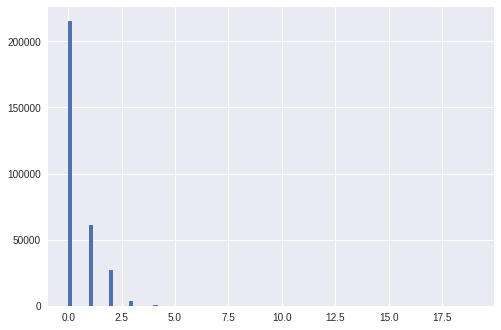

In [106]:
plt.close()
train_features.CNT_CHILDREN.hist(bins=100)
plt.show()

With this kind of skew, it's important to use the `median` instead of the `mean` when filling nulls so that the long right tail we have doesnt' bias our numbers. In general, I prefer the median over the mean when data is dense - that way you don't have to worry as much about the skew. Looking at our table of % null above, it doesn't look like `CNT_CHILDREN` has any nulls - so no filling nulls necessary here!

In [0]:
num_vars = ['CNT_CHILDREN']

The next columns are `AMT_INCOME_TOTAL`,`AMT_CREDIT`,`AMT_ANNUITY`,`AMT_GOODS_PRICE`. Looking at our nulls table above `train_features_nulls`, most of these columns don't have any nulls. `AMT_ANNUITY` and `AMT_GOODS_PRICE` do.

`AMT_ANNUITY`: Loan annuity

`AMT_GOODS_PRICE`: For consumer loans it is the price of the goods for which the loan is given

In [117]:
train_features.AMT_ANNUITY.quantile([0,0.25,0.5,0.75,1])

0.00      1615.5
0.25     16524.0
0.50     24903.0
0.75     34596.0
1.00    258025.5
Name: AMT_ANNUITY, dtype: float64

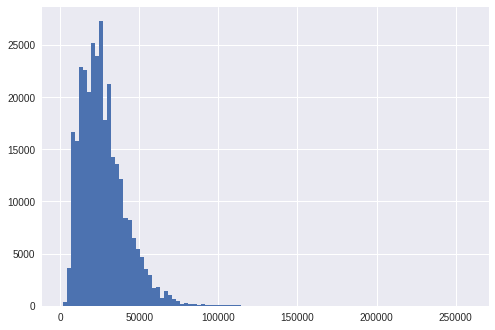

In [120]:
train_features.AMT_ANNUITY.hist(bins=100)

Also a right skew. Let's use the median to fill null values:

In [0]:
med = train_features.AMT_ANNUITY.median()

In [0]:
# Edward's code
# Using fillna

train_features.AMT_ANNUITY.fillna(med, inplace=True)
# I think you could also get rid of the function before getting median and just do
# train_features.AMT_ANNUITY.fillna(train_features.AMT_ANNUITY.median(), inplace=True)

In [151]:
train_features.AMT_ANNUITY = train_features.AMT_ANNUITY.apply(lambda x: med if x == float('nan') else x)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [152]:
train_features.AMT_ANNUITY.isnull().sum()

0

That didn't work. Maybe nulls aren't `float('nan')`? Let's check:

In [135]:
[x for x in train_features.AMT_ANNUITY if x*0 != 0]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [0]:
n = [x for x in train_features.AMT_ANNUITY if x*0 != 0][0]

We can try the same x * 0 trick to determine nulls in the dataframe. It's not the cleanest way, but it works for now:

In [144]:
train_features.AMT_ANNUITY = train_features.AMT_ANNUITY.apply(lambda x: med if x*0 != 0 else x)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [153]:
train_features.AMT_ANNUITY.isnull().sum()

0

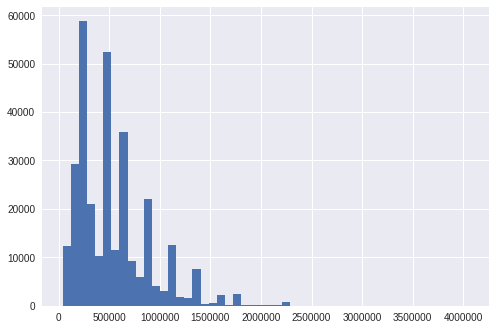

In [155]:
train_features.AMT_GOODS_PRICE.hist(bins=50)

Also a skew.

In [0]:
med = train_features.AMT_GOODS_PRICE.median()

In [158]:
train_features.AMT_GOODS_PRICE = train_features.AMT_GOODS_PRICE.apply(lambda x: med if x*0 != 0 else x)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [159]:
train_features.AMT_GOODS_PRICE.isnull().sum()

0

In [0]:
current_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

for col in current_cols:
  
  num_vars.append(current_cols)

Looking at `NAME_TYPE_SUITE`, this is a categorical column and we will create dummies from it. We can leave the nulls here.

In [161]:
train_features.NAME_TYPE_SUITE.unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

In [0]:
cat_vars.append('NAME_TYPE_SUITE')

Let's look at this group now:

```
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
```

In [164]:
for col in ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']:
  
  print(col,train_features[col].unique())
  print('--')

NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
--
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
--
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
--
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
--


These are all cat vars and we can create dummies for them.

In [0]:
for col in ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']:
  
  cat_vars.append(col)

`REGION_POPULATION_RELATIVE` is defined as "Normalized population of region where client lives (higher number means the client lives in more populated region)".

There's an important keyword here - normalized! Although not relevant for all models, normalization can help models that rely on linearity. Taking another look, there are many columns with normalized (and therefore numeric) data:

```
REGION_POPULATION_RELATIVE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
FONDKAPREMONT_MODE
HOUSETYPE_MODE
TOTALAREA_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
```

This is a lot of columns - for now, let's fill nulls with medians and call it good.

In [0]:
current_cols = ['REGION_POPULATION_RELATIVE',\
'EXT_SOURCE_1',\
'EXT_SOURCE_2',\
'EXT_SOURCE_3',\
'APARTMENTS_AVG',\
'BASEMENTAREA_AVG',\
'YEARS_BEGINEXPLUATATION_AVG',\
'YEARS_BUILD_AVG',\
'COMMONAREA_AVG',\
'ELEVATORS_AVG',\
'ENTRANCES_AVG',\
'FLOORSMAX_AVG',\
'FLOORSMIN_AVG',\
'LANDAREA_AVG',\
'LIVINGAPARTMENTS_AVG',\
'LIVINGAREA_AVG',\
'NONLIVINGAPARTMENTS_AVG',\
'NONLIVINGAREA_AVG',\
'APARTMENTS_MODE',\
'BASEMENTAREA_MODE',\
'YEARS_BEGINEXPLUATATION_MODE',\
'YEARS_BUILD_MODE',\
'COMMONAREA_MODE',\
'ELEVATORS_MODE',\
'ENTRANCES_MODE',\
'FLOORSMAX_MODE',\
'FLOORSMIN_MODE',\
'LANDAREA_MODE',\
'LIVINGAPARTMENTS_MODE',\
'LIVINGAREA_MODE',\
'NONLIVINGAPARTMENTS_MODE',\
'NONLIVINGAREA_MODE',\
'APARTMENTS_MEDI',\
'BASEMENTAREA_MEDI',\
'YEARS_BEGINEXPLUATATION_MEDI',\
'YEARS_BUILD_MEDI',\
'COMMONAREA_MEDI',\
'ELEVATORS_MEDI',\
'ENTRANCES_MEDI',\
'FLOORSMAX_MEDI',\
'FLOORSMIN_MEDI',\
'LANDAREA_MEDI',\
'LIVINGAPARTMENTS_MEDI',\
'LIVINGAREA_MEDI',\
'NONLIVINGAPARTMENTS_MEDI',\
'NONLIVINGAREA_MEDI',\
'FONDKAPREMONT_MODE',\
'HOUSETYPE_MODE',\
'TOTALAREA_MODE',\
'WALLSMATERIAL_MODE',\
'EMERGENCYSTATE_MODE']

In [167]:
for col in current_cols:
  
  med = train_features[col].median()
  
  train_features[col] = train_features[col].apply(lambda x: med if x*0 != 0 else x)
  
  num_vars.append(col)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
train_features.describe(include='all')

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


What we are doing here, basically, is just get_dummies for each table, getting the count of past records and then averaging the tables to get unique values of SK_ID_CURR. 
This is pretty basic but could be effective feature engineering.

In [0]:
pp_cols = []

In [0]:
print('Bureau_balance preprocess')
bureau_balance = pd.get_dummies(bureau_balance)

print('Counting bureaus')
bb_counts = bureau_balance[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
bureau_balance['bb_count'] = bureau_balance['SK_ID_BUREAU'].map(bb_counts['MONTHS_BALANCE'])

print('averaging bureau bal')
avg_bureau_bal = bureau_balance.groupby('SK_ID_BUREAU').mean()

avg_bureau_bal.reset_index(inplace=True)

del bureau_balance, bb_counts
gc.collect()

In [0]:
print('Bureau preprocess, includes merging bureau_balance preprocess')
bureau = pd.get_dummies(bureau)

bureau_full = bureau.merge(avg_bureau_bal, how='left', on='SK_ID_BUREAU')

print('Counting buro per SK_ID_CURR')
nb_bureau_per_curr = bureau_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
bureau_full['SK_ID_BUREAU'] = bureau_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

print('Averaging bureau')
avg_bureau = bureau_full.groupby('SK_ID_CURR').mean()

avg_bureau.columns = ['avg_bureau_' + f_ for f_ in avg_bureau.columns]
avg_bureau.reset_index(inplace = True)
pp_cols.append('avg_bureau')

del bureau, bureau_full, nb_bureau_per_curr
gc.collect()

In [0]:
print('Prev_app preprocess')
prev_app = pd.get_dummies(prev_app)

print('Counting number of prevs')
nb_prevs = prev_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_app['SK_ID_PREV'] = prev_app['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Averaging prev')
avg_prev = prev_app.groupby('SK_ID_CURR').mean()

avg_prev.columns = ['avg_prev_' + f_ for f_ in avg_prev.columns]
avg_prev.reset_index(inplace=True)
pp_cols.append('avg_prev')

del prev_app, nb_prevs
gc.collect()

In [0]:
print('Pos preprocess')
pos = pd.get_dummies(pos)

print('Counting number of prevs')
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Averaging pos')
avg_pos = pos.groupby('SK_ID_CURR').mean()

avg_pos.columns = ['avg_pos_' + f_ for f_ in avg_pos.columns]
avg_pos.reset_index(inplace=True)
pp_cols.append('avg_pos')

del pos, nb_prevs
gc.collect()

In [0]:
print('Cc_bal preprocess')
cc_bal = pd.get_dummies(cc_bal)

print('COunting number of prevs')
nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Averaging cc_bal')
avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()

avg_cc_bal.columns = ['avg_cc_bal_' + f_ for f_ in avg_cc_bal.columns]
avg_cc_bal.reset_index(inplace=True)
pp_cols.append('avg_cc_bal')

del cc_bal, nb_prevs
gc.collect()

In [0]:
print('Inst preprocess')
print('No categorical cols')

print('Counting number of prevs')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Averaging inst')
avg_inst = inst.groupby('SK_ID_CURR').mean()

avg_inst.columns = ['avg_inst_' + f_ for f_ in avg_inst.columns]
avg_inst.reset_index(inplace=True)
pp_cols.append('avg_inst')

del inst, nb_prevs
gc.collect()

In [0]:
#lets merge our train and test to create a bigger dataset to preprocess on
test['is_test'] = 1 
test['is_train'] = 0
train['is_test'] = 0
train['is_train'] = 1

In [0]:
X_train = train.drop(['TARGET'], axis = 1)
y_train = train['TARGET']
X_train.shape

In [0]:
X_test = test
X_test.shape

In [0]:
data = pd.concat([X_train, X_test], axis=0)
data = pd.get_dummies(data)

In [0]:
pp_cols

In [0]:
#this could be automated with a function perhaps
data = data.merge(avg_bureau, how='left', on='SK_ID_CURR')
data = data.merge(avg_prev, how='left', on='SK_ID_CURR')
data = data.merge(avg_pos, how='left', on='SK_ID_CURR')
data = data.merge(avg_cc_bal, how='left', on='SK_ID_CURR')
data = data.merge(avg_inst, how='left', on='SK_ID_CURR')
data.shape

In [0]:
del avg_bureau, avg_prev, avg_pos, avg_cc_bal, avg_inst
gc.collect()

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [0]:
missing_values_table(data)

In [0]:
# Get the columns with > 60% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 60].index)
print('We will remove %d columns.' % len(missing_columns))

In [0]:
# Drop the columns
data = data.drop(labels = list(missing_columns), axis=1)

In [0]:
missing_data = data[data.columns[data.isnull().sum()>0]]

In [0]:
data = data.fillna(data.mean())

In [0]:
ignore_features = ['SK_ID_CURR','is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
X_train = data[data['is_train']==1][relevant_features]
test_tf = data[data['is_test']==1][relevant_features]

In [0]:
X_train.shape

In [0]:
test_tf.shape

In [0]:
test_tf.head()

In [0]:
#x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.20)

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
#x_test = sc.transform(x_test)
test_tf = sc.transform(test_tf)

In [0]:
'''
folds = KFold(n_splits=5, shuffle=True, random_state=38)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])'''

In [0]:
y_train = y_train.values

## Building XGB model

In [0]:
'''
for n_folds, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[trn_idx], y_train[trn_idx]
    val_x, val_y = X_train[val_idx], y_train[val_idx]
    
    clf = XGBClassifier(
        max_depth=8
        , subsample=.8
        , colsample_bytree=.8
        , reg_alpha=.1
        , reg_lambda=.1
    )
    
    clf.fit(trn_x, trn_y
           , eval_set=[(trn_x, trn_y), (val_x, val_y)]
           , eval_metric='auc'
           , verbose=100
           , early_stopping_rounds=100
           )
    oof_preds[val_idx] = clf.predict_proba(val_x)[:,1]
    sub_preds += clf.predict_proba(test_tf)[:,1] / folds.n_splits'''

In [0]:
clf = XGBClassifier(
        max_depth=8
        , subsample=.8
        , colsample_bytree=.8
        , reg_alpha=.1
        , reg_lambda=.1
)

In [0]:
clf.fit(X_train, y_train)

In [0]:
test_preds = clf.predict_proba(test_tf)[:,1]
pred_df = pd.DataFrame()
pred_df['SK_ID_CURR'] = test['SK_ID_CURR']
pred_df['TARGET'] = test_preds
pred_df.to_csv('NN_baseline.csv', index=False)
pred_df.head(20)